In [56]:
import os 

In [57]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot'

In [58]:
os.chdir("../.")

In [59]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [60]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/AI-powered-Bank-Product-Recommender-Chatbot"
os.chdir(project_dir)

In [61]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    """
    Data Transformation Configuration
    """
    root_dir: Path
    transformed_data_file: Path
    customer_path: Path
    product_path: Path
    train_data_file: Path
    test_data_file: Path
    target_column: str
    joined_data_file: Path

In [62]:
from BankProducts.constants import *
from BankProducts.utils.common import read_yaml, create_directories

In [63]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,    
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH,
        ):
       
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)        
    
        create_directories([self.config.artifacts_root])
        
    def get_data_transformation_config(self)-> DataTransformationConfig:
        """
        Returns Data Transformation Configuration
        """
        config = self.config.data_transformation
        schema =  self.schema.target_column
        
        create_directories([self.config.artifacts_root])
        
        data_transformation_config = DataTransformationConfig(
            root_dir=Path(config.root_dir),
            transformed_data_file= Path(config.transformed_data_file),
            product_path= Path(config.product_path),
            customer_path= Path(config.customer_path),
            train_data_file= Path(config.train_data_file),
            test_data_file= Path(config.test_data_file),
            target_column= schema.name,
            joined_data_file= Path(config.joined_data_file)
            )
        
        
        return data_transformation_config
    

In [64]:



import os  
from BankProducts import logger
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


     


In [65]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
        #self.data = None
        #self.transformed_data = None
        
    def join_datasets(self):
        """
        Join customer and product datasets"""    
        try:
            customer_data = pd.read_csv(self.config.customer_path)
            product_data = pd.read_csv(self.config.product_path)

            # Ensure the directory for saving exists
            output_dir = os.path.dirname(self.config.transformed_data_file)
            os.makedirs(output_dir, exist_ok=True)

            # Join operation
            joined_data = pd.merge(customer_data, product_data, how="left",
                                left_on="existing_products", right_on="product_name")
            
            #drop unnecessary columns
            joined_data = joined_data.drop(columns=['existing_products'], errors='ignore')  # Drop columns which are not needed if it exists
            
            #check the dataset head
            print(joined_data.head())
            
            
            # Save the joined data
            try:   
                joined_data.to_csv(self.config.joined_data_file, index=False)
                logger.info(f"Joined dataset saved to {self.config.joined_data_file}")
                print(f"Joined dataset saved to {self.config.joined_data_file}")
            except Exception as e:
                logger.error(f"Error saving joined dataset: {e}")
                print(f"Error saving joined dataset: {e}")
            
            return joined_data

        except Exception as e:
            logger.error(f"Error in joining datasets: {e}")
            print(f"Error in joining datasets: {e}")
            raise e
    def transform_data(self):
        """
        Transform the data as per the requirements
        """
        
        # Load the data
        data = pd.read_csv(self.config.joined_data_file)
        # Perform transformations
        print(data.head())
        
        print(":"*100)
        
        data.info()
        print(":"*100)
        
        data.describe()
        print(":"*100)
        print(data.columns)
        print(":"*100)
        
        #drop na
        data.dropna(inplace=True
                            )
        #check null values
        print(data.isnull().sum())
        
        #check the number of  values in the target column
        print(data[self.config.target_column].value_counts())
        
        #resize the dataset to match the number of rows in the target column
        data = data[data[self.config.target_column].notnull()]
        
        #drop unnecessary columns
        data = data.drop(columns=['customer_id','named', 'eligibility', 'description'], errors='ignore')
        
        # print the first 5 rows of the data
        data.head()
        
        
        
        #plot "product_name" histogram based of gender using seaborn
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(data=data, x= self.config.target_column, hue='gender', multiple='stack')

        # Add separated count labels above each segment
        for container in ax.containers:
            # Add offset so overlapping labels are vertically separated
            for bar in container:
                height = bar.get_height()
                if height > 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bar.get_y() + height / 2,  # Place label at the middle of the segment
                        f'{int(height)}',
                        ha='center',
                        va='center',
                        fontsize=9,
                        color='white',  # or 'black' depending on your bar color
                        weight='bold'
                    )


        plt.title("Product Name Histogram by Gender")
        plt.tight_layout()
        plt.show()
                    
        #plot "age" histogram
        plt.figure(figsize=(10,6))
        plt.hist(data["age"], bins=10, edgecolor='black', color= "orange", alpha=0.7)
        plt.title("Age Frequency Distribution")
        plt.xlabel("Age")
        plt.ylabel("Frequency")
        plt.savefig("age_histogram.png")
        
    
        
        #plot "product_name" vs "age" bar plot
        plt.figure(figsize=(10,6))
        plt.bar(data["product_name"], data["age"], color="green")
        plt.title("Product Name vs Age Bar Plot")
        plt.xlabel("Product Name")
        plt.ylabel("Age")
        plt.savefig("product_name_vs_age_bar_plot.png")
        
        #feature selection
        # If it's a categorical variable like a string, correlation won't work correctly
        correlation_matrix = data.select_dtypes(include= ['float64', 'int64']).corr()
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
        plt.title("Correlation Matrix")
        plt.show()
        plt.savefig('correlation_matrix.png')
    
        # Save the data to a CSV file to the specified path
        os.makedirs(os.path.dirname(self.config.transformed_data_file), exist_ok=True)
        data.to_csv(self.config.transformed_data_file, index=False)
        logger.info(f"Transformed data saved to {self.config.transformed_data_file}")
        print(f"Transformed data saved to {self.config.transformed_data_file}")
        
        return data
      
    def split_data(self):
        data =  pd.read_csv(self.config.transformed_data_file)  
        
        #  splitting data into train and test sets
        train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
        
        # print the first 5 rows of the train and test data
        print("Train Data:")
        print(train_data.head())
        
        print("Test Data:") 
        print(test_data.head())
        
        
        #save train_data and test_data to csv files
        train_data.to_csv(os.path.join(self.config.train_data_file), index=False)
        test_data.to_csv(os.path.join(self.config.test_data_file), index=False)
        
        logger.info(f"Train and test sets saved to {self.config.train_data_file} and {self.config.test_data_file}")
        print(f"Train and test sets saved to {self.config.train_data_file} and {self.config.test_data_file}")
        # Log the shapes of the train and test sets
        logger.info(f"Train set shape: {train_data.shape}, Test set shape: {test_data.shape}")
        #print the shapes of the train and test sets
        print(f"Train set shape: {train_data.shape}, Test set shape: {test_data.shape}")
        # Log the shapes of the train and test sets
        return train_data, test_data    
        
        
      

[2025-05-26 16:35:31,999: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-05-26 16:35:32,005: INFO: common: yaml file: params.yaml loaded successfully]
[2025-05-26 16:35:32,011: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-05-26 16:35:32,014: INFO: common: created directory at: artifacts]
[2025-05-26 16:35:32,015: INFO: common: created directory at: artifacts]
                            customer_id              name  age  gender  \
0  f1fff826-fb41-4431-9bb7-bea6b82042b2        Shawn Hill   59    Male   
1  2ff80a89-dde4-47c1-bb19-8d6f993fb47f     Allison Lopez   26    Male   
2  afb9e62a-40a9-410f-8959-0cd74e2b047b  Stephanie Gibson   40    Male   
3  d85b51a3-cd31-4f6f-890d-ae403d8ebc18        James Mora   54  Female   
4  45e0c5fe-8c73-4e0a-975a-e4e4fbec0488      Joseph Brown   61    Male   

                                    occupation  annual_income marital_status  \
0                         Maintenance engineer      194386.47       Di

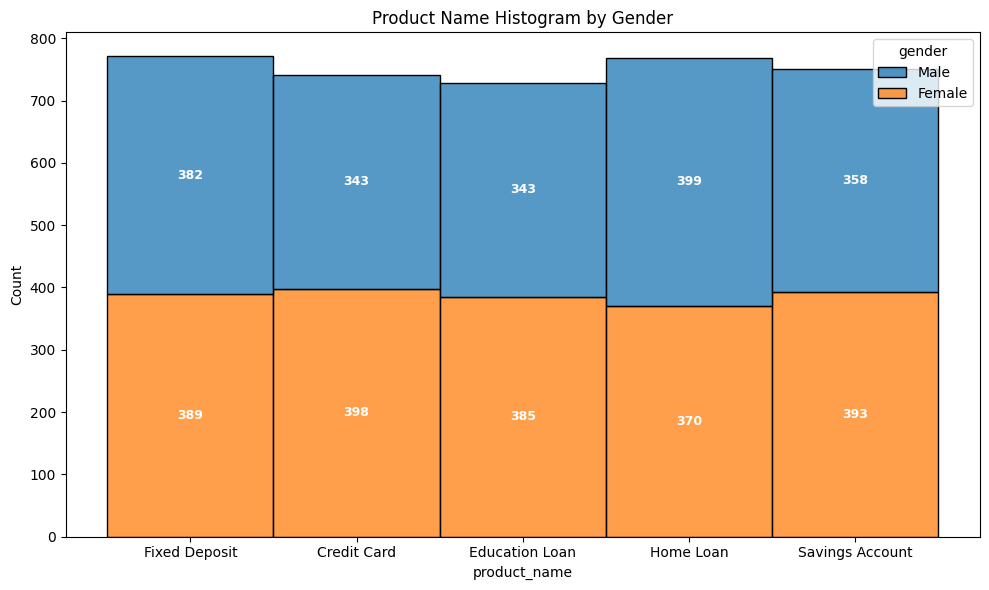

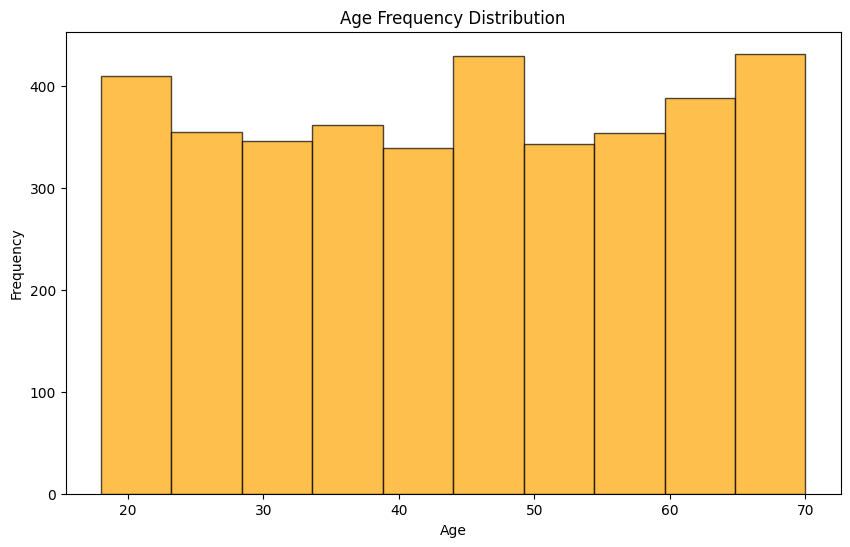

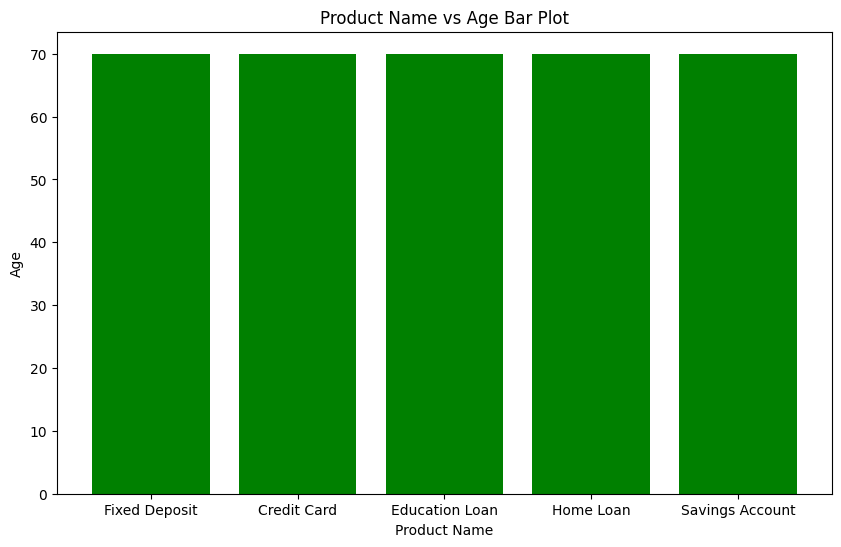

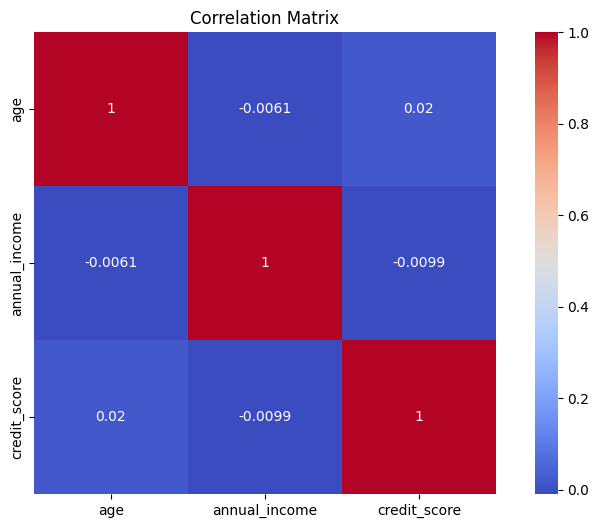

[2025-05-26 16:35:38,612: INFO: 1806668911: Transformed data saved to artifacts\data_transformation\transformed_data.csv]
Transformed data saved to artifacts\data_transformation\transformed_data.csv
Train Data:
                  name  age  gender                occupation  annual_income  \
2987      Erica Wilson   44  Female  Teacher, adult education      166056.88   
1089  Melissa Davis MD   33    Male         Medical physicist       92308.54   
2943        Michael Wu   45    Male        Engineer, drilling      121999.68   
485     Nicole Edwards   42  Female    Psychologist, forensic       43540.53   
2181    Michael Morgan   24  Female             Advice worker      114546.33   

     marital_status  credit_score financial_goals     product_name  
2987       Divorced           766      Retirement   Education Loan  
1089       Divorced           426      Retirement      Credit Card  
2943         Single           778       Education  Savings Account  
485        Divorced           35

<Figure size 640x480 with 0 Axes>

In [66]:

try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    
    data_transformation = DataTransformation(config=data_transformation_config)
    
    data_transformation.join_datasets()
    data_transformation.transform_data()
    data_transformation.split_data()
    

except Exception as e:
    print(f"An error occurred: {e}")
    
    